# Self-Driving Car Engineer Nanodegree

## **Vehicle detection and tracking** 

![Cover](./writeup_imgs/cover.jpg)

---

## Overview

In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/miguelangel/sdc--vehicle-detection-and-tracking). 

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. A great writeup should include the [rubric](https://review.udacity.com/#!/rubrics/513/view) points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.


## Goals/Steps

The goals / steps of this project are the following:
* Import and initialize the packages needed in the project.
* Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image.
* Implement a function that computes binned color features from an image.
* Implement a function that computes color histogram features from an image.
* Combine the previous feature extractors on a function
* Extract features from the dataset, and split them in training and testing sets
* Normalize the features 
* Train a Linear SVM classifier.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Implement Hog Sub-sampling Window Search, a more efficient method for doing the sliding window
* Handle multiple detections and false positives
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Step 0: Import and initialize the packages needed in the project

In [1]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.svm import LinearSVC
import time


# My humble tribute to Michael Jordan, 
# the best basketball player ever.
np.random.seed(23)

%matplotlib inline

### Step 1: Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image

In [2]:
# This function returns HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened)
    and an optional matrix for visualization. Features will always be the
    first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        block_norm='L2-Hys', transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        
        return hog_features, hog_image
    else:
        hog_features = return_list
        
        return hog_features

In [3]:
# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

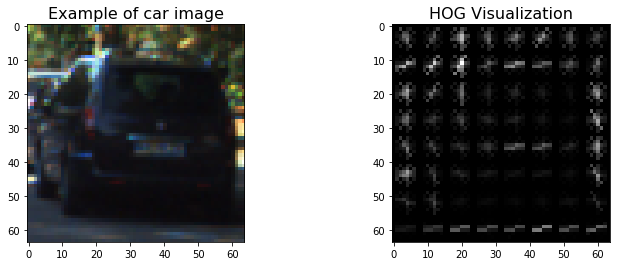

In [4]:
# Run the function on car images
#car_images = glob.glob('./data/vehicles_smallset/*/*.jpeg')
car_images = glob.glob('./data/vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(car_images))

# Read in the image and convert it to grayscale
car_img = mpimg.imread(car_images[ind])
gray_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_img, orient=9, pix_per_cell=8,
                                    cell_per_block=2, vis=True, feature_vec=False)

# Plot results
plt_images(car_img, 'Example of car image', hog_image, 'HOG Visualization')

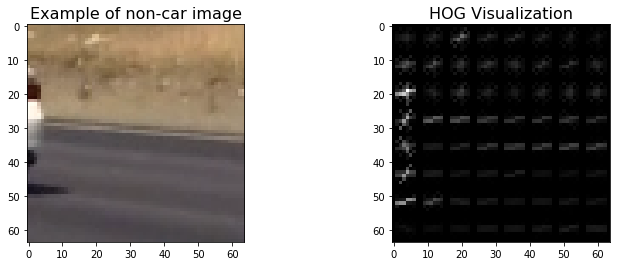

In [5]:
# Run the function also on non-car images
#non_car_images = glob.glob('./data/non-vehicles_smallset/*/*.jpeg')
non_car_images = glob.glob('./data/non-vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(non_car_images))

# Read in the image and convert it to grayscale
non_car_img = mpimg.imread(non_car_images[ind])
gray_img = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_img, orient= 9, pix_per_cell= 8,
                               cell_per_block= 2, vis=True, feature_vec=False)

hog_features = get_hog_features(gray_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)


# Plot results
plt_images(non_car_img, 'Example of non-car image', hog_image, 'HOG Visualization')

### Step 2: Implement a function that computes binned color features from an image

In [6]:
# This function computes binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

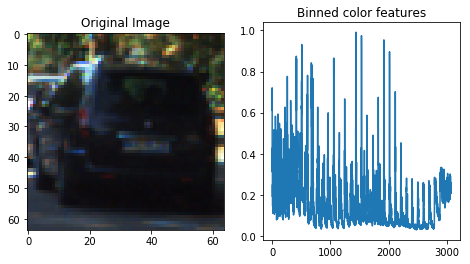

In [7]:
# Run the function
spatial_features = bin_spatial(car_img, size=(32, 32))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Binned color features')
plt.plot(spatial_features)

### Step 3: Implement a function that computes color histogram features from an image

In [8]:
# This function computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

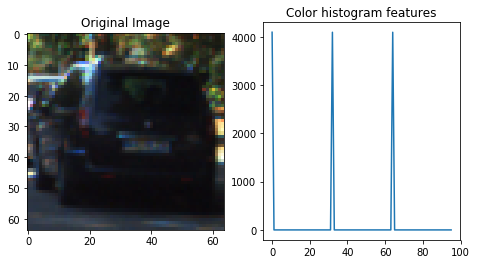

In [9]:
# Run the function
hist_features = color_hist(car_img, nbins=32, bins_range=(0, 256))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Color histogram features')
plt.plot(hist_features)

### Step 4: Combine the previous feature extractors on a function

In [10]:
# This function converts an image to a different color space
def convert_color(img, conv=''):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    return np.copy(img)

# This function extracts features from an image
def single_img_features(img, conv='', orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),                          
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion
    feature_image = convert_color(img, conv)        
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Append features to list
        img_features.append(spatial_features)

    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
     
        # Append features to list
        img_features.append(hist_features)

    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
# This function extracts features from a list of paths to images
def extract_features(imgs, conv='', orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)

        features.append(single_img_features(img, conv=conv, orient=orient,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_size=spatial_size,
                    hist_bins=hist_bins, hist_range=hist_range,
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))

    # Return list of feature vectors
    return features

### Step 5: Extract features from the dataset, and split them in training and testing sets

In [12]:
# Parameters
conv = 'RGB2YUV' # Can be '', 'RGB2HSV', 'RGB2HLS','RGB2LUV', 'RGB2YUV', 'RGB2YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0, 256)
spatial_feat=False 
hist_feat=False
hog_feat=True
y_start_stop=[300, 720]
scale=1.5

# Extract features from car and non_car datasets
car_features = extract_features(car_images, conv=conv, orient=orient,
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_size=spatial_size,
                hist_bins=hist_bins, hist_range=hist_range,
                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
     

non_car_features = extract_features(non_car_images, conv=conv, orient=orient,
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_size=spatial_size,
                hist_bins=hist_bins, hist_range=hist_range,
                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
     

# Create features and labels dataset
features = np.vstack((car_features, non_car_features)).astype(np.float64)
car_labels = np.ones(len(car_features))
non_car_labels = np.zeros(len(non_car_features))
labels = np.concatenate((car_labels, non_car_labels))

# Split our dataset in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=23)

# Print the results
print ("The dataset is balanced:")
print ("- Number of car_images:", len(car_images))
print ("- Number of non_car images:", len(non_car_images))
print ()
print ("Number of samples:")
print ("- In training set:", X_train.shape[0])
print ("- In testing set:", X_test.shape[0])
print ()
print ("X_train before normalization:")
print (X_train)

The dataset is balanced:
- Number of car_images: 8792
- Number of non_car images: 8968

Number of samples:
- In training set: 14208
- In testing set: 3552

X_train before normalization:
[[  5.56231365   3.57017465   4.85980569 ...  11.56287429  11.37839054
    9.10901952]
 [  1.65399885   1.34300224   1.65393854 ... 199.56095065  75.63689369
   44.10254615]
 [  1.92208159   3.52673976   3.61885636 ...  64.39525552  69.72950752
   60.04497026]
 ...
 [  2.69629555   2.45744748   2.78125451 ...  36.07305017  23.88483634
   29.24738064]
 [  2.47632068   2.91565938   1.73216706 ...  42.63693611  60.39233398
   56.05294632]
 [  1.58529497   3.21047899   4.12927133 ...  23.30157924   6.1558172
   11.20294449]]


### Step 6: Normalize the features

In [13]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
X_train = X_scaler.transform(X_train) 
X_test = X_scaler.transform(X_test)

# Print the results
print("X_train after normalization:")
print(X_train)
print()
scaled_features = np.vstack((X_train, X_test))
print("Features mean after normalization: {:.2f}".format(np.mean(scaled_features)))
print("Features variance after normalization: {:.2f}".format(np.var(scaled_features)))


X_train after normalization:
[[-0.00736833 -0.10400329 -0.01330961 ... -0.41901059 -0.48950309
  -0.56142575]
 [-0.26422332 -0.32216733 -0.27568209 ...  3.25730309  1.23683607
   0.38998325]
 [-0.24660488 -0.10825799 -0.11487057 ...  0.6141298   1.07813097
   0.82342815]
 ...
 [-0.19572344 -0.21300116 -0.18342104 ...  0.06028737 -0.15351071
  -0.01390111]
 [-0.21018021 -0.16811674 -0.26927977 ...  0.18864456  0.82728279
   0.71489244]
 [-0.26873855 -0.1392375  -0.07309752 ... -0.18945951 -0.62981032
  -0.50449582]]

Features mean after normalization: 0.00
Features variance after normalization: 1.02


### Step 7: Train a Linear SVM classifier

In [21]:
# Use a linear SVC 
svc = LinearSVC()

# Parameters
parameters = {'C':[0.01, 0.05, 0.1]}

# Check the training time for the SVC
t=time.time()
grid = GridSearchCV(svc, parameters)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train LinearSVC...')

# Check the score of the SVC
print('Test Accuracy of LinearSVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My LinearSVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with LinearSVC')
print("Best parameters:", print (grid.best_params_))

23.97 Seconds to train LinearSVC...
Test Accuracy of LinearSVC =  0.9769
My LinearSVC predicts:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
For these 10 labels:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
0.00048 Seconds to predict 10 labels with LinearSVC
{'C': 0.05}
Best parameters: None


### Step 8: Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [22]:
# This funciton takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y).
# It returns a list of windows.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list

In [23]:
# This function receives an image and the list of windows to be searched,
# and returns a list of windows for positve detections
def search_windows(img, windows, clf, X_scaler, conv='', orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,                   
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, conv=conv, orient=orient,
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))

        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # Return windows for positive detections
    return on_windows

In [24]:
# This function draws boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

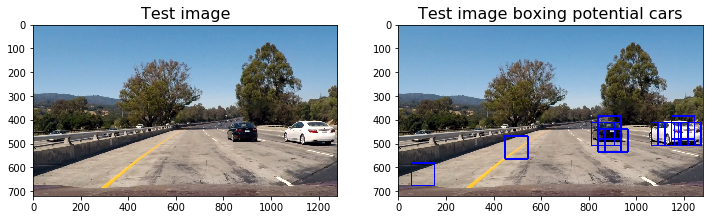

In [32]:
# Test our sliding-window technique on a sample image
img = mpimg.imread('./test_images/test1.jpg')
draw_img = np.copy(img)

# The following line is only needed when training 
# is performed with .png images (scaled 0 to 1 by mpimg)
# and the test image is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

# Create windows where to search
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))

# Search windows where cars have been found
hot_windows = search_windows(img, windows, clf, X_scaler, conv=conv, orient=orient,
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    

# Draw boxes on those windows
window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    

# Plot results
plt_images(img, 'Test image', window_img, 'Test image boxing potential cars')



### Step 9: Implement Hog Sub-sampling Window Search, a more efficient method for doing the sliding window

In [33]:
# This function extracts features using hog sub-sampling and make predictions
# It returns both, an image where potential cars are surrounded by boxes,
# and also the list of boxes
def find_cars(img, y_start_stop, scale, clf, X_scaler, conv='', orient=9, pix_per_cell=8, 
              cell_per_block=2, hog_channel=0, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),                          
              spatial_feat=True, hist_feat=True, hog_feat=True):    
    draw_img = np.copy(img)
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 0:
            hog = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 1:
            hog = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        elif hog_channel == 2:            
            hog = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)                
         
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Define an empty list to receive features
            img_features = []
            
            # Extract HOG for this patch
            if hog_feat == True: 
                if hog_channel == 'ALL':                
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:                    
                    hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                # Append features to list                    
                img_features.append(hog_features)
                    
            # Extract the image patch
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
          
            # Get color features
            if spatial_feat == True:            
                spatial_features = bin_spatial(subimg, size=spatial_size)

                # Append features to list
                img_features.append(spatial_features)

            # Compute histogram features if flag is set
            if hist_feat == True:    
                hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

                # Append features to list
                img_features.append(hist_features)                
               

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(img_features).reshape(1, -1))        
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
                                
    return draw_img, box_list
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


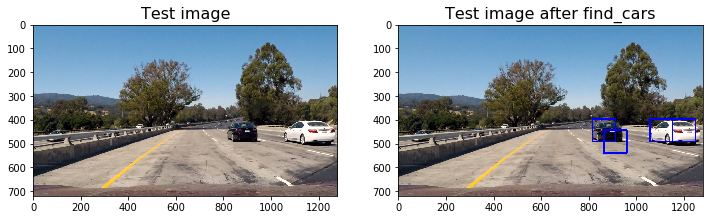

In [34]:

    
out_img, box_list = find_cars(img, y_start_stop, scale, clf, X_scaler, conv=conv, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                    spatial_size=(spatial_size), hist_bins=hist_bins, hist_range=hist_range,
                    spatial_feat=spatial_feat, hist_feat=spatial_feat, hog_feat=hog_feat)

# Plot results
plt_images(img, 'Test image', out_img, 'Test image after find_cars')

### Step 10: Handle multiple detections and false positives

In [35]:
# This function adds "heat" to a map for a list of bounding boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap 

# This function zero outs heatmap pixels which are below a threshold 
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


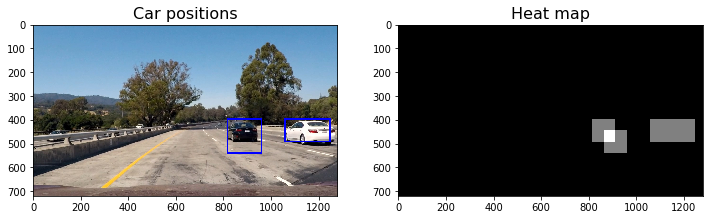

In [42]:
# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0.7)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

# Plot results
#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(draw_img)
#plt.title('Car Positions')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')
#fig.tight_layout()

plt_images(draw_img, 'Car positions', heatmap, 'Heat map')
